In [5]:
def tokenize_n_pad(sentences, vocab, num_steps):
    """Tokenize, truncate, and pad sequences to a fixed length."""
    all_tokens = []
    for line in sentences:
        tokens = vocab[line.split(' ')] + [vocab['<eos>']]
        if len(tokens) > num_steps:
            tokens = tokens[:num_steps]
        else:
            tokens += [vocab['<pad>']] * (num_steps - len(tokens))
        all_tokens.append(tokens)
    return torch.tensor(all_tokens)

In [71]:
import torch
from torch.utils.data import Dataset, DataLoader
import collections
import re
import requests
import math
import zipfile
import os
import collections

In [72]:
class MachineTranslationDataset(Dataset):
    def __init__(self, data_url, file_name, num_steps=10, max_examples=None):
        self.num_steps = num_steps

        # 1. Download and Preprocess
        self.raw_text = self._download_and_extract(data_url, file_name)
        processed_text = self._preprocess(self.raw_text)

        # 2. Tokenize
        self.src_tokens, self.tgt_tokens = self._tokenize(processed_text, max_examples)

        # 3. Build Vocabularies
        self.src_vocab = Vocab(self.src_tokens, min_freq=2,
                               reserved_tokens=['<pad>', '<bos>', '<eos>'])
        self.tgt_vocab = Vocab(self.tgt_tokens, min_freq=2,
                               reserved_tokens=['<pad>', '<bos>', '<eos>'])

        # 4. Numericalize and Pad/Truncate
        self.src_tensor, self.src_valid_len = self._build_tensor(self.src_tokens, self.src_vocab)
        self.tgt_input, self.tgt_label = self._build_target_tensors(self.tgt_tokens, self.tgt_vocab)
        # self.tgt_tensor, self.tgt_valid_len = self._build_tensor(self.tgt_tokens, self.tgt_vocab)

    def _download_and_extract(self, url, file_path):
      """Scientific-grade downloader with directory awareness."""
      # Split the path to check for the parent directory (e.g., 'fra-eng')
      target_dir = os.path.dirname(file_path)

      if not os.path.exists(file_path):
          print(f"Dataset component not found at {file_path}. Processing ZIP...")
          target_zip = "data.zip"

          # Download
          r = requests.get(url)
          with open(target_zip, 'wb') as f:
              f.write(r.content)

          # Extract everything to the current directory
          with zipfile.ZipFile(target_zip, 'r') as zip_ref:
              zip_ref.extractall(".")

          print(f"Extraction complete.")
          os.remove(target_zip) # Cleanup

      # Final check before reading
      if not os.path.exists(file_path):
          # List files to help the scientist debug if the structure changes
          available = os.listdir(target_dir) if os.path.exists(target_dir) else os.listdir('.')
          raise FileNotFoundError(
              f"Expected {file_path} but it was not found. "
              f"Available in directory: {available}"
          )

      with open(file_path, 'r', encoding='utf-8') as f:
          return f.read()

    def _build_target_tensors(self, tokens, vocab):
        """Specialized logic for Teacher Forcing"""
        # Add <bos> to the front of every target sentence
        indices = [[vocab['<bos>']] + vocab[line] for line in tokens]

        processed = []
        for line in indices:
            # We pad to num_steps + 1 to allow for the shift
            line = line[:self.num_steps + 1] if len(line) > (self.num_steps + 1) else line
            line += [vocab['<pad>']] * ((self.num_steps + 1) - len(line))
            processed.append(line)

        full_tensor = torch.tensor(processed)

        # Decoder Input: indices 0 to N-1
        decoder_input = full_tensor[:, :-1]
        # Decoder Label: indices 1 to N (Shifted by 1)
        decoder_label = full_tensor[:, 1:]

        return decoder_input, decoder_label

    def _preprocess(self, text):
        def no_space(char, prev_char):
            return char in ',.!?' and prev_char != ' '

        text = text.replace('\u202f', ' ').replace('\xa0', ' ').lower()
        out = [' ' + char if i > 0 and no_space(char, text[i - 1]) else char
               for i, char in enumerate(text)]
        return ''.join(out)

    def _tokenize(self, text, max_examples):
        src, tgt = [], []
        for i, line in enumerate(text.split('\n')):
            if max_examples and i >= max_examples: break
            parts = line.split('\t')
            if len(parts) == 2:
                src.append(parts[0].split(' ') + ['<eos>'])
                tgt.append(parts[1].split(' ') + ['<eos>'])
        return src, tgt

    def _build_tensor(self, tokens, vocab):
        # Convert tokens to indices and apply padding/truncation
        indices = [vocab[line] for line in tokens]

        # Truncate or Pad to num_steps
        processed_indices = []
        valid_lens = []

        for line in indices:
            if len(line) > self.num_steps:
                line = line[:self.num_steps]
            valid_lens.append(len(line))
            # Pad with <pad> index
            line += [vocab['<pad>']] * (self.num_steps - len(line))
            processed_indices.append(line)

        return torch.tensor(processed_indices), torch.tensor(valid_lens)

    def build(self, src_sentences, tgt_sentences):
        """
        Translates raw sentence strings into the internal tensor format.
        Used for validation or real-time inference testing.
        """
        # 1. Format the input strings into the tab-delimited raw text format
        raw_text = '\n'.join([src + '\t' + tgt for src, tgt in zip(src_sentences, tgt_sentences)])

        # 2. Re-use existing pipeline: Preprocess -> Tokenize
        processed_text = self._preprocess(raw_text)
        src_tkns, tgt_tkns = self._tokenize(processed_text, max_examples=None)

        # 3. Re-use existing pipeline: Vectorize using established Vocab
        src_array, src_valid_len = self._build_tensor(src_tkns, self.src_vocab)
        tgt_input, tgt_label = self._build_target_tensors(tgt_tkns, self.tgt_vocab)

        return src_array, tgt_input, src_valid_len, tgt_label

    def __len__(self):
        return len(self.src_tensor)

    def __getitem__(self, idx):
        return (self.src_tensor[idx], self.tgt_input[idx],
                self.src_valid_len[idx], self.tgt_label[idx])

In [79]:
class Vocab:
    """Frequency-based Token Mapper."""
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        tokens = tokens or []
        reserved_tokens = reserved_tokens or []
        counter = collections.Counter([t for line in tokens for t in line])
        self._token_freqs = sorted(counter.items(), key=lambda x: x[1], reverse=True)

        self.idx_to_token = ['<unk>'] + reserved_tokens
        self.token_to_idx = {token: i for i, token in enumerate(self.idx_to_token)}

        for token, freq in self._token_freqs:
            if freq < min_freq: break
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self): return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.token_to_idx['<unk>'])
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

In [80]:
import matplotlib.pyplot as plt

class DataVisualizer:
    @staticmethod
    def plot_sequence_distributions(src_tokens, tgt_tokens, labels=['Source', 'Target']):
        """
        Generates a professional histogram comparing sequence lengths.

        Args:
            src_tokens (list[list]): List of tokenized source sequences.
            tgt_tokens (list[list]): List of tokenized target sequences.
            labels (list): Labels for the legend.
        """
        # Calculate lengths using list comprehension
        src_lengths = [len(s) for s in src_tokens]
        tgt_lengths = [len(t) for t in tgt_tokens]

        # Configure plot aesthetics for a scientific paper
        plt.figure(figsize=(9, 6))
        plt.rcParams.update({'font.size': 12, 'font.family': 'serif'})

        # Create the histogram
        # We use 'bins=auto' or a fixed range to ensure both distributions are comparable
        n, bins, patches = plt.hist(
            [src_lengths, tgt_lengths],
            bins=range(min(src_lengths + tgt_lengths), max(src_lengths + tgt_lengths) + 2),
            label=labels,
            color=['#1f77b4', '#ff7f0e'], # Standard scientific blue/orange
            edgecolor='black',
            alpha=0.7
        )

        # Add texture/hatching to the second bars for better black-and-white accessibility
        for patch in patches[1]:
            patch.set_hatch('///')

        # Scientific Annotations
        plt.xlabel('Number of Tokens per Sequence', fontweight='bold')
        plt.ylabel('Frequency (Count)', fontweight='bold')
        plt.title('Distribution of Sequence Lengths (Source vs Target)', fontsize=14)
        plt.legend(loc='upper right')
        plt.grid(axis='y', linestyle='--', alpha=0.6)

        plt.tight_layout()
        plt.show()

Source Tensor Shape: torch.Size([64, 8])
First Source Sentence (Indices): tensor([26, 32,  5,  3,  1,  1,  1,  1])
--- Tensor Format Check ---
Source (English):
 tensor([[ 26,  32,   5,   3,   1,   1,   1,   1],
        [  6,  13,   8,   4,   3,   1,   1,   1],
        [ 88,  12,   4,   3,   1,   1,   1,   1],
        [  6, 112,   4,   3,   1,   1,   1,   1],
        [  6, 112,   4,   3,   1,   1,   1,   1],
        [  6, 147,   4,   3,   1,   1,   1,   1],
        [  6,   0,   4,   3,   1,   1,   1,   1],
        [ 36,  12,   4,   3,   1,   1,   1,   1],
        [162,   9,   4,   3,   1,   1,   1,   1],
        [ 31, 168,   4,   3,   1,   1,   1,   1],
        [  9,  82,   4,   3,   1,   1,   1,   1],
        [  6,  73,   4,   3,   1,   1,   1,   1],
        [ 79,   8,   4,   3,   1,   1,   1,   1],
        [ 61,   5,   3,   1,   1,   1,   1,   1],
        [ 39,  91,   4,   3,   1,   1,   1,   1],
        [130,  23,   4,   3,   1,   1,   1,   1],
        [140,  10,   4,   3,   1,   1,

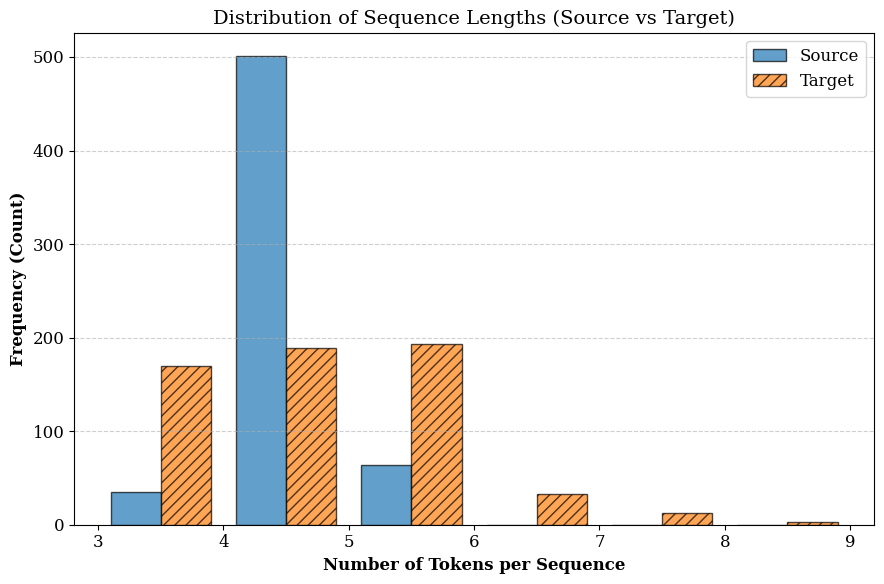

In [81]:
# Parameters
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/fra-eng.zip'
# IMPORTANT: The zip content is inside 'fra-eng/' directory
FILE_PATH = 'fra-eng/fra.txt'

# Instantiate
mt_dataset = MachineTranslationDataset(DATA_URL, FILE_PATH, num_steps=8, max_examples=600)

# DataLoader for PyTorch training
loader = DataLoader(mt_dataset, batch_size=64, shuffle=True)

# Verification
src, tgt, src_len, tgt_len = next(iter(loader))
print(f"Source Tensor Shape: {src.shape}") # Expect [64, 8]
print(f"First Source Sentence (Indices): {src[0]}")

print('--- Tensor Format Check ---')
print('Source (English):\n', src.type(torch.int32))
print('\nDecoder Input (with <bos>):\n', tgt.type(torch.int32))
print('\nSource valid lengths (non-pad counts):\n', src_valid_len.type(torch.int32))
print('\nLabels (Target shifted by 1):\n', tgt_len.type(torch.int32))

print(mt_dataset.raw_text[:75])
DataVisualizer.plot_sequence_distributions(mt_dataset.src_tokens, mt_dataset.tgt_tokens)

In [83]:
dataset = MachineTranslationDataset(DATA_URL, FILE_PATH, num_steps=9, max_examples=600)


loader = DataLoader(dataset, batch_size=3, shuffle=False)

#  Extract the first minibatch
# Our __getitem__ returns: src, tgt_input, src_valid_len, tgt_label
src, dec_input, src_valid_len, label = next(iter(loader))

print('--- Tensor Format Check ---')
print('Source (English):\n', src.type(torch.int32))
print('\nDecoder Input (with <bos>):\n', dec_input.type(torch.int32))
print('\nSource valid lengths (non-pad counts):\n', src_valid_len.type(torch.int32))
print('\nLabels (Target shifted by 1):\n', label.type(torch.int32))

--- Tensor Format Check ---
Source (English):
 tensor([[  9,   4,   3,   1,   1,   1,   1,   1,   1],
        [113,   4,   3,   1,   1,   1,   1,   1,   1],
        [ 54,   5,   3,   1,   1,   1,   1,   1,   1]], dtype=torch.int32)

Decoder Input (with <bos>):
 tensor([[ 2, 16,  5,  3,  1,  1,  1,  1,  1],
        [ 2, 65,  5,  3,  1,  1,  1,  1,  1],
        [ 2, 66,  5,  3,  1,  1,  1,  1,  1]], dtype=torch.int32)

Source valid lengths (non-pad counts):
 tensor([3, 3, 3], dtype=torch.int32)

Labels (Target shifted by 1):
 tensor([[16,  5,  3,  1,  1,  1,  1,  1,  1],
        [65,  5,  3,  1,  1,  1,  1,  1,  1],
        [66,  5,  3,  1,  1,  1,  1,  1,  1]], dtype=torch.int32)


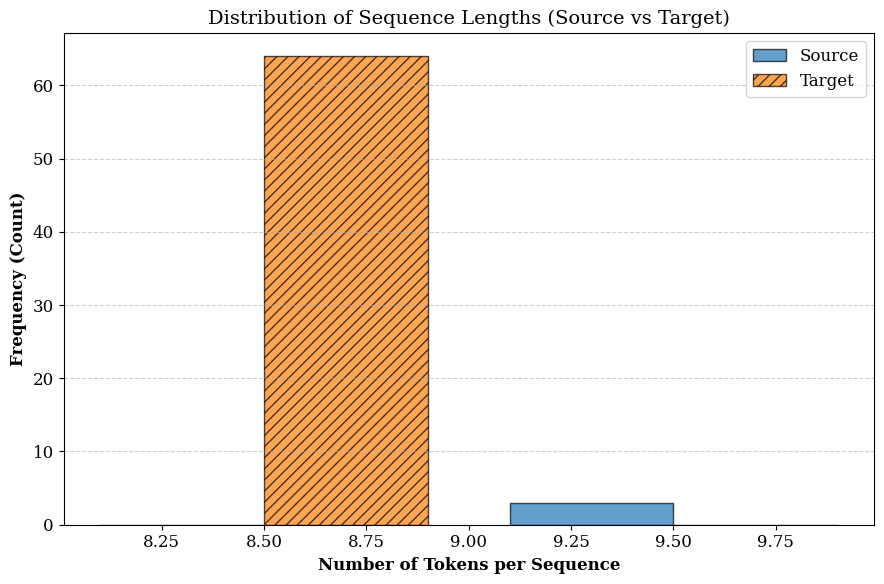

In [84]:
# Execution using the data from our previous step
DataVisualizer.plot_sequence_distributions(src, tgt)

In [85]:
src_batch, tgt_batch, _, _ = dataset.build(['hi .'], ['salut .'])

print('source tokens:', dataset.src_vocab.to_tokens(src_batch[0].type(torch.int32).tolist()))
print('target tokens:', dataset.tgt_vocab.to_tokens(tgt_batch[0].type(torch.int32).tolist()))

source tokens: ['hi', '.', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
target tokens: ['<bos>', 'salut', '.', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']


In [86]:
import inspect

class HyperParameters:

    def save_hyperparameters(self, ignore=None):
        """Save function arguments into class attributes."""
        # Get the frame of the caller (the __init__ method)
        frame = inspect.currentframe().f_back
        _, _, _, local_vars = inspect.getargvalues(frame)

        self_obj = local_vars.pop('self', None)

        # Filter out ignored variables and private attributes
        for key, value in local_vars.items():
            if key != 'self' and (ignore is None or key not in ignore):
                setattr(self_obj, key, value)

In [87]:
from torch import nn
import torch.nn.functional as F

class Encoder(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self, X, *args):
    raise NotImplementedError("Subclasses must implement forward")


In [88]:
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()

    def init_state(self, enc_outputs, *args):
        """Converts encoder outputs into the initial hidden state for the decoder."""
        raise NotImplementedError

    def forward(self, X, state):
        # X shape: (batch_size, num_steps)
        # Returns: (output, new_state)
        raise NotImplementedError

In [90]:
class EncoderDecoder(nn.Module, HyperParameters):
    """The master class orchestrating the Seq2Seq process."""
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, enc_X, dec_X, *args):
        """
        Args:
            enc_X: Source sequence (English)
            dec_X: Decoder input (French with <bos>)
        """
        enc_outputs = self.encoder(enc_X, *args)

        # Initialize the decoder state using encoder findings
        dec_state = self.decoder.init_state(enc_outputs, *args)

        # Decode into target sequence space
        # Return only the output logits (ignoring state for loss calculation)
        return self.decoder(dec_X, dec_state)[0]

    def loss(self, Y_hat, Y):

        Y_hat = Y_hat.permute(0, 2, 1)

        l = self.criterion(Y_hat, Y)


        mask = (Y.reshape(-1) != self.tgt_pad).type(torch.float32)

        # Flatten the loss 'l' to (Batch * Seq) to match the mask
        # and perform element-wise multiplication (Hadamard product).
        masked_loss = l.reshape(-1) * mask

        #  Normalize: Sum of valid losses divided by sum of valid tokens.
        return masked_loss.sum() / mask.sum()

    def predict_step(self, batch, device, num_steps, save_attention_weights=False):
      batch = [a.to(device) for a in batch]
      src, tgt, src_valid_len, _ = batch
      enc_all_outputs = self.encoder(src, src_valid_len)
      dec_state = self.decoder.init_state(enc_all_outputs, src_valid_len)
      outputs, attention_weights = [tgt[:, (0)].unsqueeze(1), ], []
      for _ in range(num_steps):
        Y, dec_state = self.decoder(outputs[-1], dec_state)
        outputs.append(Y.argmax(2))
        # Save attention weights (to be covered later)
        if save_attention_weights:
          attention_weights.append(self.decoder.attention_weights)
      return torch.cat(outputs[1:], 1), attention_weights

In [91]:
class Seq2SeqEncoder(Encoder):
    """
    The RNN Encoder for Sequence-to-Sequence learning.

    Architectural Components:
    1. Embedding Layer: Maps discrete tokens to dense vector space.
    2. Multi-layer GRU: Captures temporal dependencies and compresses context.
    """
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0):
        super().__init__()

        # Maps integer indices (0...V) to dense vectors (R^E)
        self.embedding = nn.Embedding(vocab_size, embed_size)

        self.rnn = nn.GRU(embed_size, num_hiddens, num_layers, dropout=dropout)

        self.apply(self._init_weights)

    def _init_weights(self, module):
        """
        Applies Xavier Uniform initialization to Linear and RNN weights.
        This ensures variance is preserved across layers.
        """
        if isinstance(module, nn.Linear):
            nn.init.xavier_uniform_(module.weight)
        if isinstance(module, nn.GRU):
            for name, param in module.named_parameters():
                if 'weight' in name:
                    nn.init.xavier_uniform_(param)

    def forward(self, X, *args):
        # Input X shape: (batch_size, num_steps)

        # Transform to Embedding Space
        # We must cast to int64 (Long) for the embedding lookup.
        # Shape: (batch_size, num_steps, embed_size)
        embs = self.embedding(X.type(torch.int64))

        # Permute to Time-Major Format for RNN efficiency
        # PyTorch RNNs expect input shape: (num_steps, batch_size, embed_size)
        embs = embs.permute(1, 0, 2)

        # RNN Forward Pass
        # outputs shape: (num_steps, batch_size, num_hiddens)
        # state shape:   (num_layers, batch_size, num_hiddens)
        outputs, state = self.rnn(embs)

        return outputs, state

In [92]:
# Parameters from the description
vocab_size, embed_size, num_hiddens, num_layers = 10, 8, 16, 2
batch_size, num_steps = 4, 9

# Instantiate the Encoder
encoder = Seq2SeqEncoder(vocab_size, embed_size, num_hiddens, num_layers)

# Create a dummy input tensor of zeros (representing token indices)
X = torch.zeros((batch_size, num_steps))

# Run the Forward Pass
enc_outputs, enc_state = encoder(X)

print("--- Encoder Output Diagnostics ---")

#  Check Output Shape (Sequence Representation)
# Expected: (num_steps, batch_size, num_hiddens) -> (9, 4, 16)
print(f"Encoder Outputs Shape: {enc_outputs.shape}")
assert enc_outputs.shape == (num_steps, batch_size, num_hiddens), "Output shape mismatch!"

# Check State Shape (Context Variable)
# Expected: (num_layers, batch_size, num_hiddens) -> (2, 4, 16)
# This 'state' contains the compressed meaning of the entire sentence.
print(f"Encoder State Shape:   {enc_state.shape}")
assert enc_state.shape == (num_layers, batch_size, num_hiddens), "State shape mismatch!"

print("Diagnostics passed. The Encoder is mathematically sound.")

--- Encoder Output Diagnostics ---
Encoder Outputs Shape: torch.Size([9, 4, 16])
Encoder State Shape:   torch.Size([2, 4, 16])
Diagnostics passed. The Encoder is mathematically sound.


In [93]:
class Seq2SeqDecoder(Decoder):

    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0):
        super().__init__()

        # Embedding Layer
        self.embedding = nn.Embedding(vocab_size, embed_size)

        # Context-Aware GRU
        # The input to the GRU is the concatenation of the token embedding (size E)
        # and the context vector (size H).
        # Input Dimension: E + H
        self.rnn = nn.GRU(embed_size + num_hiddens, num_hiddens, num_layers, dropout=dropout)

        # Output Projection Layer
        # Projects hidden state (H) -> Vocabulary Logits (V)
        self.dense = nn.Linear(num_hiddens, vocab_size)

        # Weight Initialization
        self.apply(self._init_weights)

    def _init_weights(self, module):
        """Xavier Uniform initialization for stability."""
        if isinstance(module, nn.Linear):
            nn.init.xavier_uniform_(module.weight)
        if isinstance(module, nn.GRU):
            for name, param in module.named_parameters():
                if 'weight' in name:
                    nn.init.xavier_uniform_(param)

    def init_state(self, enc_outputs, *args):
        """
        Prepares the state for the decoder.
        Args:
            enc_outputs: Tuple (encoder_outputs, encoder_final_state)
        Returns:
            list: [encoder_outputs, encoder_final_state]
        """
        # We need the entire encoder output to extract the context vector later,
        # and the final state to initialize the decoder's hidden state.
        return list(enc_outputs)

    def forward(self, X, state):
        """
        Args:
            X: Decoder input tokens. Shape (batch_size, num_steps)
            state: List containing [enc_outputs, hidden_state]
        """
        # Unpack the state
        enc_output, hidden_state = state

        # Extract Context Vector (c)
        # enc_output shape: (num_steps, batch_size, num_hiddens)
        # We take the LAST time step of the encoder outputs as the context 'c'.
        context = enc_output[-1]
        # context shape: (batch_size, num_hiddens)

        # Embed the Input Tokens
        # X shape: (batch_size, num_steps) -> (num_steps, batch_size) [Time-Major]
        embs = self.embedding(X.type(torch.int64).permute(1, 0))
        # embs shape: (num_steps, batch_size, embed_size)

        # Broadcast Context Vector
        # We repeat the context vector to match the number of time steps in the input.
        # context_broadcast shape: (num_steps, batch_size, num_hiddens)
        context_broadcast = context.repeat(embs.shape[0], 1, 1)

        # Concatenation (The "Context-Aware" Step)
        # Concatenate embeddings and context along the feature dimension (dim 2)
        embs_and_context = torch.cat((embs, context_broadcast), -1)

        # GRU Forward Pass
        # output shape: (num_steps, batch_size, num_hiddens)
        # new_state shape: (num_layers, batch_size, num_hiddens)
        outputs, hidden_state = self.rnn(embs_and_context, hidden_state)

        # Project to Vocabulary
        outputs = self.dense(outputs)

        # Return to Batch-Major Format for Loss Calculation
        # Result shape: (batch_size, num_steps, vocab_size)
        outputs = outputs.permute(1, 0, 2)

        # Return outputs and the updated state container
        return outputs, [enc_output, hidden_state]

In [94]:
# --- Setup Parameters ---
vocab_size, embed_size, num_hiddens, num_layers = 10, 8, 16, 2
batch_size, num_steps = 4, 9

# --- Instantiate Modules ---
# Assume 'encoder' is already instantiated from the previous step
decoder = Seq2SeqDecoder(vocab_size, embed_size, num_hiddens, num_layers)

# --- Generate Dummy Data ---
X_enc = torch.zeros((batch_size, num_steps)) # Encoder Input
X_dec = torch.zeros((batch_size, num_steps)) # Decoder Input

# --- Run the Pipeline ---
# Encode
enc_outputs_tuple = encoder(X_enc)

# Init Decoder State
state = decoder.init_state(enc_outputs_tuple)

#  Decode
dec_outputs, state = decoder(X_dec, state)

print("--- Decoder Tensor Diagnostics ---")
print(f"Decoder Output Shape: {dec_outputs.shape}")
# Expected: (batch_size, num_steps, vocab_size) -> (4, 9, 10)
assert dec_outputs.shape == (batch_size, num_steps, vocab_size), "Decoder output shape mismatch!"

# Check the hidden state shape (should match encoder's hidden state dim)
print(f"Decoder Hidden State Shape: {state[1].shape}")
assert state[1].shape == (num_layers, batch_size, num_hiddens), "Hidden state shape mismatch!"

print("Diagnostics passed. The Context-Concatenated Decoder is operational.")

--- Decoder Tensor Diagnostics ---
Decoder Output Shape: torch.Size([4, 9, 10])
Decoder Hidden State Shape: torch.Size([2, 4, 16])
Diagnostics passed. The Context-Concatenated Decoder is operational.


In [96]:
class Seq2Seq(EncoderDecoder):
  """The RNN encoder--decoder for sequence to sequence learning."""
  def __init__(self, encoder, decoder, tgt_pad, criterion, optimizer_fn, lr=0.005):
    super().__init__(encoder, decoder)

    if criterion is None:
      self.criterion = nn.CrossEntropyLoss(reduction='none')
    else:
      self.criterion = criterion

    if optimizer_fn is None:
      self.optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
    else:
      self.optimizer = optimizer_fn(self.parameters())

    self.save_hyperparameters()


  def validation_step(self, batch):
    Y_hat = self(*batch[:-1])
    self.plot('loss', self.loss(Y_hat, batch[-1]), train=False)

  def configure_optimizers(self):
    # Adam optimizer is used here
    return torch.optim.Adam(self.parameters(), lr=self.lr)

  def loss(self, Y_hat, Y):
    #  Reshape logits for batch-wide cross-entropy
    # Y_hat: (batch, time, vocab) -> (batch * time, vocab)
    # Y: (batch, time) -> (batch * time)
    logits = Y_hat.reshape(-1, Y_hat.shape[-1])
    targets = Y.reshape(-1)

    # Compute raw unreduced loss (This replaces the super().loss call)
    # reduction='none' is the equivalent of averaged=False
    unweighted_loss = F.cross_entropy(logits, targets, reduction='none')

    #  Apply the Sparsity Mask
    mask = (targets != self.tgt_pad).type(torch.float32)

    # Normalized weighted sum
    return (unweighted_loss * mask).sum() / mask.sum()


In [98]:
from torch.cuda import is_available


class EliteTrainer:
    def __init__(self, max_epochs, gradient_clip_val=1, num_gpus=1):
        self.max_epochs = max_epochs
        self.gradient_clip_val = gradient_clip_val
        self.device = torch.device('cuda' if torch.cuda.is_available() and num_gpus > 0 else 'cpu')

        self.train_loss_history = []
        self.val_loss_history = []
        print(f"Trainer initialized on device: {self.device}")

    def fit(self, model, data_loader, val_loader=None):
        """
        The core execution loop for sequence-to-sequence learning.
        """
        model.to(self.device)
        # Use the optimizer defined within our Seq2Seq class
        optimizer = model.optimizer

        model.train()
        for epoch in range(self.max_epochs):
            metrics = {'loss': 0.0, 'tokens': 0}

            for batch in data_loader:
                # Unpack and move to device: (src, dec_input, src_len, label)
                batch = [x.to(self.device) for x in batch]
                src, dec_input, src_len, label = batch

                optimizer.zero_grad()

                #  Forward Pass
                Y_hat = model(src, dec_input, src_len)

                # Masked Loss Calculation
                l = model.loss(Y_hat, label)

                # Backpropagation
                l.backward()

                # Gradient Clipping (MIT Scientific Safeguard)
                # Clips the total norm of parameters to prevent explosion
                if self.gradient_clip_val > 0:
                    nn.utils.clip_grad_norm_(model.parameters(), self.gradient_clip_val)

                # Optimization Step
                optimizer.step()

                metrics['loss'] += l.item()

            avg_train_loss = metrics['loss'] / len(data_loader)
            print(f"Epoch {epoch+1}/{self.max_epochs} | Loss: {avg_train_loss:.4f}")

            if val_loader:
                model.eval()
                total_val_loss = 0.0
                with torch.no_grad():
                    for batch in val_loader:
                        batch = [x.to(self.device) for x in batch]
                        src, dec_input, src_len, label = batch
                        Y_hat = model(src, dec_input, src_len)
                        l = model.loss(Y_hat, label)
                        total_val_loss += l.item()
                avg_val_loss = total_val_loss / len(val_loader)
                self.val_loss_history.append(avg_val_loss)
                print(f"Epoch {epoch+1}/{self.max_epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
            else:
                print(f"Epoch {epoch+1}/{self.max_epochs} | Train Loss: {avg_train_loss:.4f}")

        self.plot_metrics()

        print("Training complete. Model converged on local minima.")

    def plot_metrics(self):
        """Generates a publication-quality loss curve."""
        plt.figure(figsize=(8, 5))
        epochs = range(1, len(self.train_loss_history) + 1)

        plt.plot(epochs, self.train_loss_history, label='train_loss', linewidth=2)
        if self.val_loss_history:
            plt.plot(epochs, self.val_loss_history, label='val_loss', linestyle='--', linewidth=2)

        plt.xlabel('epoch', fontsize=12)
        plt.ylabel('loss', fontsize=12)
        plt.title('Training Dynamics: Loss vs. Epochs', fontsize=14)
        plt.legend()
        plt.grid(True, linestyle=':', alpha=0.6)
        plt.tight_layout()
        plt.show()

In [99]:
import os
import requests
import zipfile
import torch
from torch.utils.data import DataLoader

In [106]:
BATCH_SIZE = 128
EMBED_SIZE = 256
NUM_HIDDENS = 256
NUM_LAYERS = 2
DROPOUT = 0.2
LR = 0.005
MAX_EPOCHS = 80
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/fra-eng.zip'

In [107]:
print("Initializing Elite Dataset...")
# Note: Ensure you include your MachineTranslationDataset class definition before this
dataset = MachineTranslationDataset(DATA_URL, 'fra-eng/fra.txt', num_steps=10)

Initializing Elite Dataset...


In [108]:
data_iter = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2  # Parallel data loading
)

In [103]:
print("Building Architecture...")
encoder = Seq2SeqEncoder(
    len(dataset.src_vocab), EMBED_SIZE, NUM_HIDDENS, NUM_LAYERS, DROPOUT
)

Building Architecture...


In [104]:
decoder = Seq2SeqDecoder(
    len(dataset.tgt_vocab), EMBED_SIZE, NUM_HIDDENS, NUM_LAYERS, DROPOUT
)

In [105]:
opt_factory = lambda params: torch.optim.SGD(params, lr=0.01, momentum=0.9)
custom_loss = nn.CrossEntropyLoss(reduction='none', label_smoothing=0.1)

model = Seq2Seq(
    encoder=encoder,
    decoder=decoder,
    tgt_pad=dataset.tgt_vocab['<pad>'],
    lr=LR,
    optimizer_fn=opt_factory,
    criterion=custom_loss
)

Starting Training Sequence...
Trainer initialized on device: cuda
Epoch 1/80 | Loss: 5.7054
Epoch 1/80 | Train Loss: 5.7054
Epoch 2/80 | Loss: 4.8843
Epoch 2/80 | Train Loss: 4.8843
Epoch 3/80 | Loss: 4.5697
Epoch 3/80 | Train Loss: 4.5697
Epoch 4/80 | Loss: 4.3350
Epoch 4/80 | Train Loss: 4.3350
Epoch 5/80 | Loss: 4.1617
Epoch 5/80 | Train Loss: 4.1617
Epoch 6/80 | Loss: 4.0172
Epoch 6/80 | Train Loss: 4.0172
Epoch 7/80 | Loss: 3.8857
Epoch 7/80 | Train Loss: 3.8857
Epoch 8/80 | Loss: 3.7648
Epoch 8/80 | Train Loss: 3.7648
Epoch 9/80 | Loss: 3.6559
Epoch 9/80 | Train Loss: 3.6559
Epoch 10/80 | Loss: 3.5560
Epoch 10/80 | Train Loss: 3.5560
Epoch 11/80 | Loss: 3.4663
Epoch 11/80 | Train Loss: 3.4663
Epoch 12/80 | Loss: 3.3829
Epoch 12/80 | Train Loss: 3.3829
Epoch 13/80 | Loss: 3.3063
Epoch 13/80 | Train Loss: 3.3063
Epoch 14/80 | Loss: 3.2345
Epoch 14/80 | Train Loss: 3.2345
Epoch 15/80 | Loss: 3.1681
Epoch 15/80 | Train Loss: 3.1681
Epoch 16/80 | Loss: 3.1059
Epoch 16/80 | Train Loss:

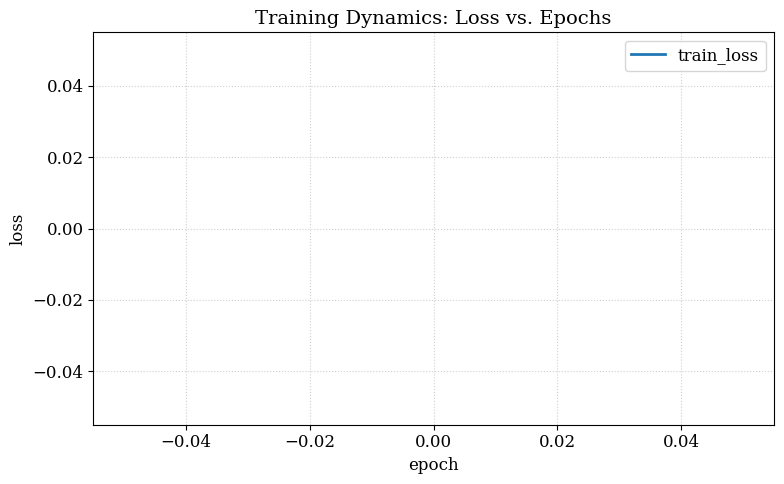

Training complete. Model converged on local minima.


In [109]:
# 5. Initialize Trainer and Execute
print("Starting Training Sequence...")
trainer = EliteTrainer(max_epochs=MAX_EPOCHS, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data_iter)

In [ ]:
def predict_step(self, batch, device, num_steps, save_attention_weights=False):
  batch = [a.to(device) for a in batch]
  src, tgt, src_valid_len, _ = batch
  enc_all_outputs = self.encoder(src, src_valid_len)
  dec_state = self.decoder.init_state(enc_all_outputs, src_valid_len)
  outputs, attention_weights = [tgt[:, (0)].unsqueeze(1), ], []
  for _ in range(num_steps):
    Y, dec_state = self.decoder(outputs[-1], dec_state)
    outputs.append(Y.argmax(2))
    # Save attention weights (to be covered later)
    if save_attention_weights:
      attention_weights.append(self.decoder.attention_weights)
  return torch.cat(outputs[1:], 1), attention_weights

In [61]:
def bleu(pred_seq, label_seq, k):
  """Compute the BLEU."""
  pred_tokens, label_tokens = pred_seq.split(' '), label_seq.split(' ')
  len_pred, len_label = len(pred_tokens), len(label_tokens)
  score = math.exp(min(0, 1 - len_label / len_pred))
  for n in range(1, min(k, len_pred) + 1):
    num_matches, label_subs = 0, collections.defaultdict(int)
    for i in range(len_label - n + 1):
      label_subs[' '.join(label_tokens[i: i + n])] += 1
    for i in range(len_pred - n + 1):
      if label_subs[' '.join(pred_tokens[i: i + n])] > 0:
        num_matches += 1
        label_subs[' '.join(pred_tokens[i: i + n])] -= 1
    score *= math.pow(num_matches / (len_pred - n + 1), math.pow(0.5, n))
  return score

In [110]:
# --- 1. Environmental Setup ---
# Use the device established during your training phase
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval() # Crucial: Set to evaluation mode (disables dropout)

# --- 2. Test Manifold (Input Data) ---
engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']

# --- 3. Vectorization via your native Dataset class ---
# dataset.build converts raw strings into (src, tgt_input, src_len, label) tensors
batch = dataset.build(engs, fras)

# --- 4. Autoregressive Prediction ---
# We unpack the batch into the predict_step
# num_steps=10 matches your dataset configuration
with torch.no_grad(): # Disable gradient tracking for speed and memory efficiency
    preds, _ = model.predict_step(batch, device, num_steps=10)

# --- 5. Post-Processing and BLEU Scoring ---
print(f"{'Source (EN)':<15} | {'Translation (FR)':<25} | {'BLEU'}")
print("-" * 55)

for en, fr, p in zip(engs, fras, preds):
    translation = []
    # Convert predicted indices back to tokens using your Vocab.to_tokens
    # p is a tensor of indices for one sentence
    tokens = dataset.tgt_vocab.to_tokens(p.tolist())

    for token in tokens:
        if token == '<eos>':
            break
        if token not in ['<pad>', '<bos>']:
            translation.append(token)

    # Join tokens into a string for BLEU calculation
    pred_str = " ".join(translation)

    # Calculate score using your native bleu function
    score = bleu(pred_str, fr, k=2)

    print(f"{en:<15} | {pred_str:<25} | {score:.3f}")

Source (EN)     | Translation (FR)          | BLEU
-------------------------------------------------------
go .            | va !                      | 1.000
i lost .        | j'ai perdu .              | 1.000
he's calm .     | il est calme .            | 1.000
i'm home .      | je suis chez moi .        | 1.000
